In [17]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [2]:
#HYPERPARAMETERS
BATCH_SIZE = 4
EPOCHS = 13
STEP_SIZE = 0.0009
MOMENTUM = 0.9

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


C:\Users\R\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
#CNN FOR SHADOW AND TARGET MODELS OF MNIST
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
       
        self.fc1 = nn.Linear(576, 576)
        self.fc2 =  nn.Linear(576, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.batchnorm2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.batchnorm3(x)
        
        x = x.view(-1, 576)
        x = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(x), dim = 1)
        return out

In [10]:
#FULLY CONNECTED MODEL FOR THE ATTACKER

class Net_Attack(nn.Module):
    def __init__(self):
        super(Net_Attack, self).__init__()
        
        self.fc1 = nn.Linear(10, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        
        
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x =  self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x =  self.batchnorm2(x)
        x = F.relu(self.fc3(x))
        x =  self.batchnorm3(x)
        out = F.softmax(self.fc4(x), dim = 1)
        return out

In [11]:
shadow = Net()
target = Net()
attack = Net_Attack()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(shadow.parameters(), lr=STEP_SIZE, momentum = 0.9)
optimizer2 = torch.optim.SGD(target.parameters(), lr=STEP_SIZE, momentum = 0.9)
optimizer3 = torch.optim.SGD(attack.parameters(), lr=0.0002, momentum = 0.9)

In [13]:
#TRAINING SHADOW & TARGET MODELS
for epoch in range(EPOCHS): 
    print (epoch)
    epoch_loss = 0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        

        #TRAIN SHADOW MODEL
        if i < 6000:
            optimizer1.zero_grad()
            outputs = shadow(images)
            loss1 = criterion(outputs, labels)
            loss1.backward()
            optimizer1.step()
            
            epoch_loss += outputs.shape[0] * loss1.item()

        # print epoch loss
        
        if i == 6000:
            
            print(epoch+1, epoch_loss / 24000)
            
            if epoch == 0:
                loss_per_epoch_shadow = np.array(epoch_loss) / 24000
                epoch_loss = 0
            else:
                loss_per_epoch_shadow = np.append(loss_per_epoch_shadow, np.array(epoch_loss) / 24000)
                epoch_loss = 0
            
            
                     
        #TRAIN TARGET MODEL
        if i > 6000:     
            optimizer2.zero_grad()
            outputs = target(images)
            loss2 = criterion(outputs, labels)
            loss2.backward()
            optimizer2.step()
            
            
                            # print statistics
            epoch_loss += outputs.shape[0] * loss2.item()

    # print epoch loss
    print(epoch+1, epoch_loss / 24000)
    if epoch == 0:
        loss_per_epoch_target = np.array(epoch_loss) / 24000
    else:
        loss_per_epoch_target = np.append(loss_per_epoch_target, np.array(epoch_loss) / 24000)

            
            
#save both models
torch.save(shadow.state_dict(), "shadow_model_MNIST.pt")
torch.save(target.state_dict(), "target_model_MNIST.pt")

0
1 1.5967107198437056
1 2.3416233416001
1
2 1.4867556506991386
2 2.221504112581412
2
3 1.477010103146235
3 2.2107841359376907
3
4 1.472312023361524
4 2.2060207805832226
4
5 1.4691991389989854
5 2.2027738602161406
5
6 1.4674803257981937
6 2.20065391822656
6
7 1.4663025115331014
7 2.199029579122861
7
8 1.4652576810717584
8 2.197882402201494
8
9 1.4645487556656203
9 2.1970490437746046
9
10 1.4641010349194208
10 2.19655060950915
10
11 1.4639023965199789
11 2.1961051953434945
11
12 1.4636611521840095
12 2.195785739958286
12
13 1.4635398460626603
13 2.1955464402635894


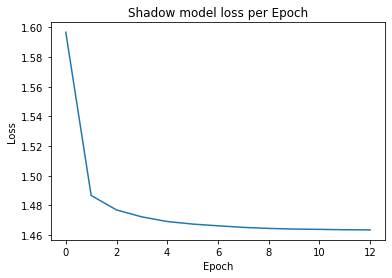

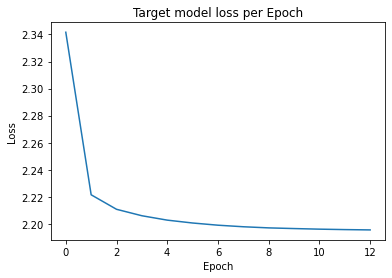

In [14]:
x = np.arange(EPOCHS)
plt.plot(x, loss_per_epoch_shadow)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Shadow model loss per Epoch")
plt.show()

plt.plot(x, loss_per_epoch_target)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Target model loss per Epoch")
plt.show()

In [15]:
def PRINT_ACC(predicted_shadow, predicted_target, ground_truth):
    predicted_shadow = torch.flatten(predicted_shadow).numpy()  
    predicted_target = torch.flatten(predicted_target).numpy()  
    ground_truth = torch.flatten(ground_truth).numpy()  
    print("Train Accuracy of shadow model is:",np.sum((predicted_shadow == ground_truth))/len(ground_truth))
    print("Shadow model's Precision for training dataset is:", precision_score(ground_truth, predicted_shadow, average='macro'))
    print("Shadow model's Recall for training dataset is:",recall_score(ground_truth, predicted_shadow, average='macro'))
    print("Test Accuracy of target model is:",np.sum((predicted_target == ground_truth))/len(ground_truth))
    print("Target model's Precision for testing dataset is:", precision_score(ground_truth, predicted_target, average='macro'))
    print("Target model's Recall for testing dataset is:",recall_score(ground_truth, predicted_target, average='macro'))

In [18]:
# TRAIN & TEST ACCURACY OF OUR SHADOW & TARGET MODELS

for i, data in enumerate(trainloader, 0):
    
    #first 6000 * 4 examples were trained on shadow model so we get train accuracy of shadow model
    # and test accuracy of target model
    if i > 6000:
        break
    images, labels = data
    outputs_shadow = shadow(images)
    outputs_target = target(images)
    if i ==0:
        _, Shadow = torch.max(outputs_shadow, 1)
        _, Target = torch.max(outputs_target, 1)
        predicted_shadow = Shadow
        predicted_target = Target
        ground_truth = labels
    else:
        _, Shadow = torch.max(outputs_shadow, 1)
        _, Target = torch.max(outputs_target, 1)
        predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
        predicted_target = torch.cat((predicted_target, Target), 0)
        ground_truth = torch.cat((ground_truth, labels), 0)

PRINT_ACC(predicted_shadow, predicted_target, ground_truth)


Train Accuracy of shadow model is: 0.9980419930011665
Shadow model's Precision for training dataset is: 0.9980450984344256
Shadow model's Recall for training dataset is: 0.9980411558029498
Test Accuracy of target model is: 0.9894600899850025
Target model's Precision for testing dataset is: 0.9893256177470334
Target model's Recall for testing dataset is: 0.9894723034309523


In [19]:
#TRAINING ATTACK MODEL
epochs = EPOCHS
loss_per_epoch = 0
for epoch in range(epochs):
    
    running_loss = 0
    epoch_loss = 0
    train_iterator = iter(trainloader)
    test_iterator = iter(testloader)

    for i in range(6000):
        
        optimizer3.zero_grad()
    
        if i%3==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(train_iterator)
            
        posteriors = shadow(images)        
        outputs_attack = attack(posteriors)    
        loss3 = criterion(outputs_attack, from_train)
        loss3.backward()
        optimizer3.step()
       
        epoch_loss += outputs.shape[0] * loss3.item()

        # print statistics
        running_loss += loss3.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000), outputs_attack)
            running_loss = 0.0

    # print epoch loss
    print(epoch+1, epoch_loss / len(trainset))
    if epoch == 0:
        loss_per_epoch = np.array(epoch_loss) / len(trainset)
    else:
        loss_per_epoch = np.append(loss_per_epoch, np.array(epoch_loss) / len(trainset))
            
#Plot Epoch vs loss
x = np.arange(EPOCHS)

#SAVE ATTACK MODEL
torch.save(attack.state_dict(), "attack_model_MNIST.pt")

[1,  2000] loss: 0.671 tensor([[0.4429, 0.5571],
        [0.3629, 0.6371],
        [0.3143, 0.6857],
        [0.2587, 0.7413]], grad_fn=<SoftmaxBackward>)
[1,  4000] loss: 0.649 tensor([[0.3175, 0.6825],
        [0.2071, 0.7929],
        [0.2435, 0.7565],
        [0.3266, 0.6734]], grad_fn=<SoftmaxBackward>)
[1,  6000] loss: 0.642 tensor([[0.2557, 0.7443],
        [0.2146, 0.7854],
        [0.2146, 0.7854],
        [0.2422, 0.7578]], grad_fn=<SoftmaxBackward>)
1 0.2616195712924004
[2,  2000] loss: 0.640 tensor([[0.1799, 0.8201],
        [0.1979, 0.8021],
        [0.2572, 0.7428],
        [0.2026, 0.7974]], grad_fn=<SoftmaxBackward>)
[2,  4000] loss: 0.638 tensor([[0.1320, 0.8680],
        [0.1732, 0.8268],
        [0.1967, 0.8033],
        [0.2927, 0.7073]], grad_fn=<SoftmaxBackward>)
[2,  6000] loss: 0.637 tensor([[0.2201, 0.7799],
        [0.1693, 0.8307],
        [0.1693, 0.8307],
        [0.1654, 0.8346]], grad_fn=<SoftmaxBackward>)
2 0.25538438352147735
[3,  2000] loss: 0.638 tens

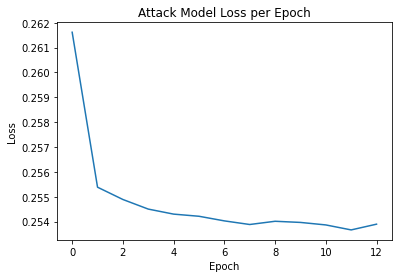

In [20]:
plt.plot(x, loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Attack Model Loss per Epoch')
plt.show()

In [21]:
def PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth, Train = True):
    predicted_shadow = torch.flatten(predicted_shadow).numpy()
    predicted_target = torch.flatten(predicted_target).numpy()
    ground_truth = torch.flatten(ground_truth).numpy()  
    if Train == True:
        print ("Attack model Statistics using shadow model's Posteriors and training dataset")
        print (classification_report(ground_truth, predicted_shadow))
        print ("Attack model Statistics using target model's Posteriors and testing dataset")
        print (classification_report(ground_truth, predicted_target))
        print("Train Accuracy of attack model on Shadow Model's Posteriors ", 
              np.sum((predicted_shadow == ground_truth))/len(ground_truth),
              "Test Accuracy of attack model on Target Model's Posteriors ", 
              np.sum((predicted_target == ground_truth))/len(ground_truth),
              "Shadow model's Precision for training dataset is:",
              precision_score(ground_truth, predicted_shadow),
              "Shadow model's Recall for training dataset is:",
              recall_score(ground_truth, predicted_shadow))
              
    else:
        print ("Attack model Statistics using shadow model's Posteriors and testing dataset")
        print (classification_report(ground_truth, predicted_shadow))
        print ("Attack model Statistics using target model's Posteriors and training dataset")
        print (classification_report(ground_truth, predicted_target))
        print("Test Accuracy of attack model on Shadow Model's Posteriors ", 
              np.sum((predicted_shadow == ground_truth))/len(ground_truth),
              "Test Accuracy of attack model on Target Model's Posteriors ", 
              np.sum((predicted_target == ground_truth))/len(ground_truth),
              "Shadow model's Precision for testing dataset is:",
              precision_score(ground_truth, predicted_shadow),
              "Shadow model's Recall for testing dataset is:",
              recall_score(ground_truth, predicted_shadow))

In [27]:
attack_model = Net_Attack()
attack_model.load_state_dict(torch.load('./attack_model_MNIST.pt'))

<All keys matched successfully>

In [28]:
# Checking Attack Model Train Accuracy
train_iterator = iter(trainloader)
test_iterator = iter(testloader)
for i in range(6000):

    from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)

    if i%3==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
    else:
        #Use images from shadow/target model's train dataset
        from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
        images, labels = next(train_iterator)
            

    # Finding Train Accuracy of Shadow Model
    posteriors_shadow = shadow(images)    
    #posteriors_shadow = torch.cat((posteriors_shadow, torch.reshape(labels, (BATCH_SIZE, 1))), 1)
    outputs_attack_shadow = attack(posteriors_shadow)
    
    # Finding Train Accuracy of Target Model
    posteriors_target = target(images)   
    #posteriors_target = torch.cat((posteriors_target, torch.reshape(labels, (BATCH_SIZE, 1))), 1)
    outputs_attack_target = attack(posteriors_target)

    
    if i ==0:
        _, Shadow = torch.max(outputs_attack_shadow, 1)
        _, Target = torch.max(outputs_attack_target, 1)

        predicted_shadow = Shadow
        predicted_target = Target
        ground_truth = from_train
    else:
        _, Shadow = torch.max(outputs_attack_shadow, 1)
        _, Target = torch.max(outputs_attack_target, 1)
        
        predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
        predicted_target = torch.cat((predicted_target, Target), 0)
        ground_truth = torch.cat((ground_truth, from_train), 0)
        

PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth)

Attack model Statistics using shadow model's Posteriors and training dataset
              precision    recall  f1-score   support

           0       0.61      0.04      0.07      8000
           1       0.67      0.99      0.80     16000

    accuracy                           0.67     24000
   macro avg       0.64      0.51      0.44     24000
weighted avg       0.65      0.67      0.56     24000

Attack model Statistics using target model's Posteriors and testing dataset
              precision    recall  f1-score   support

           0       0.59      0.04      0.07      8000
           1       0.67      0.99      0.80     16000

    accuracy                           0.67     24000
   macro avg       0.63      0.51      0.43     24000
weighted avg       0.64      0.67      0.56     24000

Train Accuracy of attack model on Shadow Model's Posteriors  0.671375 Test Accuracy of attack model on Target Model's Posteriors  0.67025 Shadow model's Precision for training dataset is: 0.672

In [29]:
# Checking Attack Model Test Accuracy
train_iterator = iter(trainloader)
test_iterator = iter(testloader)
for i in range(8000):

    if i<6000:
        if i%3==0:
            #Use images from shadow/target model's test dataset
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            images, labels = next(train_iterator)
        

    

    # For test we use only the last 1000*4 = 4000 images (1000 from test set of cifar10 and 9000 from trainset of cifar 10) 
    # both our shadow and target model have not previously seen these images 
    elif i>6000:
        
        if i%4==0:
            #Use images from shadow/target model's test dataset
            from_train = torch.zeros((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(test_iterator)
        else:
            #Use images from shadow/target model's train dataset
            from_train = torch.ones((BATCH_SIZE), dtype = torch.int64)
            images, labels = next(train_iterator)
    
        posteriors_shadow = shadow(images)    
        #posteriors_shadow = torch.cat((posteriors_shadow, torch.reshape(labels, (BATCH_SIZE, 1))), 1)
        outputs_attack_shadow = attack(posteriors_shadow)



        posteriors_target = target(images)
        #posteriors_target = torch.cat((posteriors_target, torch.reshape(labels, (BATCH_SIZE, 1))), 1)
        outputs_attack_target = attack(posteriors_target)

        if i ==6001:
            _, Shadow = torch.max(outputs_attack_shadow, 1)
            _, Target = torch.max(outputs_attack_target, 1)

            predicted_shadow = Shadow
            predicted_target = Target
            ground_truth = from_train
        else:
            _, Shadow = torch.max(outputs_attack_shadow, 1)
            _, Target = torch.max(outputs_attack_target, 1)
            predicted_shadow = torch.cat((predicted_shadow, Shadow), 0)
            predicted_target = torch.cat((predicted_target, Target), 0)
            ground_truth = torch.cat((ground_truth, from_train), 0)

PRINT_ACC_ATTACK(predicted_shadow, predicted_target, ground_truth, Train = False)


Attack model Statistics using shadow model's Posteriors and testing dataset
              precision    recall  f1-score   support

           0       0.57      0.06      0.11      1996
           1       0.76      0.99      0.86      6000

    accuracy                           0.75      7996
   macro avg       0.67      0.52      0.48      7996
weighted avg       0.71      0.75      0.67      7996

Attack model Statistics using target model's Posteriors and training dataset
              precision    recall  f1-score   support

           0       0.54      0.06      0.11      1996
           1       0.76      0.98      0.86      6000

    accuracy                           0.75      7996
   macro avg       0.65      0.52      0.48      7996
weighted avg       0.70      0.75      0.67      7996

Test Accuracy of attack model on Shadow Model's Posteriors  0.7541270635317658 Test Accuracy of attack model on Target Model's Posteriors  0.7525012506253127 Shadow model's Precision for testin